In [3]:
#creating extra data from current files  

import pandas as pd
import os
from datetime import datetime
from packaging import version
from keras.callbacks import EarlyStopping, ModelCheckpoint 
import tensorboard

In [4]:
root_path = ''
list_of_files = []
for root, dir,files in os.walk('/content/drive/MyDrive/SEBI /Adjudication Orders Annotations JSON/Model Data Context'):
  root_path = root
  list_of_files = files
  break 


In [5]:
all_dataframes = []
for filename in list_of_files:
  file_path = root_path + '/' + filename
  file_temp = pd.read_csv(file_path)
  #print(file_temp.shape)
  temp_left = file_temp['Sentence']
  empty_left_first = pd.Series(' ')
  #print(type(temp_left))
  #print(empty_left_first.shape)
  file_temp['context_left'] = empty_left_first.append(temp_left,ignore_index=True)[:-1]
  #print(file_temp.head())
  temp_right = file_temp['Sentence'][1:]
  #print(len(file_temp))
  empty_right = pd.Series(' ')
  file_temp['context_right'] = temp_right.append(empty_right,ignore_index=True)
  print(file_temp.iloc[-1])
  all_dataframes.append(file_temp)


  


  

In [ ]:
all_dataframes[0].head()

,Sentence ID,Label,Sentence,context_left,context_right
0,F1312279794560_S1,material fact,Securities and Exchange Board of India (herein...,,"The Investigation, inter alia, revealed that t..."
1,F1312279794560_S2,material fact,"The Investigation, inter alia, revealed that t...",Securities and Exchange Board of India (herein...,"On August 07, 2009 the managers to the offer o..."
2,F1312279794560_S3,material fact,"On August 07, 2009 the managers to the offer o...","The Investigation, inter alia, revealed that t...",According to the Code of Conduct framed and ap...
3,F1312279794560_S4,statutory fact,According to the Code of Conduct framed and ap...,"On August 07, 2009 the managers to the offer o...","However, SIPL has No introduced any trading wi..."
4,F1312279794560_S5,material fact,"However, SIPL has No introduced any trading wi...",According to the Code of Conduct framed and ap...,"Shri K. L. Surana, (Noticee No 1) was the Comp..."


In [ ]:
!pip install bert-for-tf2 

     |████████████████████████████████| 51kB 4.8MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-cp37-none-any.whl size=30535 sha256=df23fadb958206dcf1b2f6ad5c6c750b9289238de00d79e14bdf623f936debfd
  Stored in directory: /root/.cache/pip/wheels/a1/04/ee/347bd9f5b821b637c76411d280271a857aece00358896a230f
  Created wheel for py-params: filename=py_params-0.10.2-cp37-none-any.whl size=7912 sha256=7a901f1aca3a5f4fd2caa7c44234d9116b8201150f5335e393c345f425c40b05
  Stored in directory: /root/.cache/pip/wheels/d0/4a/70/ff12450229ff1955abf01f365051d4faae1c20aef53ab4cf09
  Created wheel for params-flow: filename=params_flow-0.8.2-cp37-none-any.whl size=19472 sha256=1b6023e025ab34b87a691abded9b1fedc8d85116cb1cea652fd2cd5bc7d4e071
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [ ]:

from tqdm import tqdm
import numpy as np
import tensorflow as tf
from tensorflow import keras
import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
result = pd.DataFrame()
result = result.append(all_dataframes,ignore_index=True)

In [ ]:
train_data = pd.DataFrame(columns= result.columns)
test_data = pd.DataFrame(columns=result.columns)
for label in result.Label.unique():
  temp_df = result[result['Label'] == label]
  train_index = int(temp_df.shape[0]*0.793)
  train_data = train_data.append(temp_df[:train_index])
  test_data = test_data.append(temp_df[train_index:])
  
  

In [ ]:
train_data.drop(columns = ['Sentence ID'],axis=1,inplace=True)
test_data.drop(columns = ['Sentence ID'],axis=1, inplace=True)

In [ ]:
train_data.head()

,Label,Sentence,context_left,context_right
0,material fact,Securities and Exchange Board of India (herein...,,"The Investigation, inter alia, revealed that t..."
1,material fact,"The Investigation, inter alia, revealed that t...",Securities and Exchange Board of India (herein...,"On August 07, 2009 the managers to the offer o..."
2,material fact,"On August 07, 2009 the managers to the offer o...","The Investigation, inter alia, revealed that t...",According to the Code of Conduct framed and ap...
4,material fact,"However, SIPL has No introduced any trading wi...",According to the Code of Conduct framed and ap...,"Shri K. L. Surana, (Noticee No 1) was the Comp..."
5,material fact,"Shri K. L. Surana, (Noticee No 1) was the Comp...","However, SIPL has No introduced any trading wi...",Allegedly the trading window remained open dur...


In [ ]:
train_data['Label'].value_counts()

defendant claim           471
material fact             429
procedural fact           254
subjective observation    225
statutory fact            148
issues framed              75
related fact               68
allegation                 65
penalty                    33
violation                  24
Name: Label, dtype: int64

In [ ]:
test_data['Label'].value_counts()

defendant claim           123
material fact             113
procedural fact            67
subjective observation     59
statutory fact             39
issues framed              20
related fact               18
allegation                 17
penalty                     9
violation                   7
Name: Label, dtype: int64

In [ ]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip


--2021-04-19 09:53:24--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 66.102.1.128, 142.251.5.128, 74.125.206.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|66.102.1.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M  82.6MB/s    in 5.5s    

2021-04-19 09:53:30 (70.2 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



In [ ]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [ ]:
os.makedirs("model", exist_ok=True)


In [ ]:
!mv uncased_L-12_H-768_A-12/ model


In [ ]:

bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

In [ ]:
classes = train_data.Label.unique().tolist()
classes

['material fact',
 'statutory fact',
 'allegation',
 'violation',
 'procedural fact',
 'subjective observation',
 'defendant claim',
 'issues framed',
 'related fact',
 'penalty']

In [ ]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))


In [ ]:
train_data['context_left'].isnull

<bound method Series.isnull of 0                                                       
1      Securities and Exchange Board of India (herein...
2      The Investigation, inter alia, revealed that t...
4      According to the Code of Conduct framed and ap...
5      However, SIPL has No introduced any trading wi...
                             ...                        
911    Having considered all the facts and circumstan...
972    In view of the conclusions arrived at paras 20...
973     From the conclusions arrived at para 24 above...
981    In light of the aforesaid Order by Hon’ble SAT...
982    In view of the abovementioned conclusion along...
Name: context_left, Length: 1792, dtype: object>

In [ ]:
#preprocessing 
class Classifier:
  DATA_COLUMN = "Sentence"
  CONTEXT_COLUMN_LEFT = "context_left"
  CONTEXT_COLUMN_RIGHT = "context_right"
  LABEL_COLUMN = "Label"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    train, test = map(lambda df: df.reindex(df[Classifier.DATA_COLUMN].str.len().sort_values().index), [train, test])
  
    ((self.train_x, self.train_x_context_left,  self.train_x_context_right, self.train_y), (self.test_x, self.test_x_context_left, self.test_x_context_right , self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])
    self.train_x_context_left, self.test_x_context_left = map(self._pad, [self.train_x_context_left, self.test_x_context_left])
    self.train_x_context_right, self.test_x_context_right = map(self._pad, [self.train_x_context_right, self.test_x_context_right])

  def _prepare(self, df):
    x, y = [], []
    context_x_left, context_x_right = [] , []

    try:
      print(f"columns in the df {df.columns}")
      for _, row in tqdm(df.iterrows()):
        text,context_left, context_right , label = row[Classifier.DATA_COLUMN], row[Classifier.CONTEXT_COLUMN_LEFT], row[Classifier.CONTEXT_COLUMN_RIGHT],row[Classifier.LABEL_COLUMN]
        tokens = self.tokenizer.tokenize(text)
        context_tokens_left = self.tokenizer.tokenize(context_left)
        context_tokens_right = self.tokenizer.tokenize(context_right)
        tokens = ["[CLS]"] + tokens + ["[SEP]"]
        context_tokens_left = ["[CLS]"] + context_tokens_left + ["[SEP]"]
        context_tokens_right = ["[CLS]"] + context_tokens_right + ["[SEP]"]
        token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        context_token_ids_left = self.tokenizer.convert_tokens_to_ids(context_tokens_left)
        context_token_ids_right = self.tokenizer.convert_tokens_to_ids(context_tokens_right)
        self.max_seq_len = max(self.max_seq_len, len(context_token_ids_left),len(context_tokens_right))
        x.append(token_ids)
        context_x_left.append(context_token_ids_left)
        context_x_right.append(context_token_ids_right)
        y.append(self.classes.index(label))
    except Exception:
      print(row)
      pass

    return np.array(x), np.array(context_x_left),np.array(context_x_right),np.array(y)

  def _pad(self, ids):
    x = []
    context_x_left, context_x_right = [], []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [ ]:

data = Classifier(train_data, test_data, tokenizer, classes, max_seq_len=512)


47it [00:00, 463.69it/s]

columns in the df Index(['Label', 'Sentence', 'context_left', 'context_right'], dtype='object')


1792it [00:05, 337.56it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
45it [00:00, 446.97it/s]

columns in the df Index(['Label', 'Sentence', 'context_left', 'context_right'], dtype='object')


472it [00:01, 328.54it/s]


max seq_len 308


In [ ]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  input_context_ids_left = keras.layers.Input(shape=(max_seq_len,), dtype='int32',name='input_context_ids_left')
  input_context_ids_right = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_context_ids_right")
  bert_output = bert(input_ids)
  bert_context_output_left = bert(input_context_ids_left)
  bert_context_output_right = bert(input_context_ids_right)


  print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:,0,:])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  
  cls_out_context_left = keras.layers.Lambda(lambda seq: keras.backend.mean(seq,axis=1))(bert_context_output_left)
  cls_out_context_left = keras.layers.Dropout(0.5)(cls_out_context_left)

  cls_out_context_right = keras.layers.Lambda(lambda seq: keras.backend.mean(seq,axis=1))(bert_context_output_right)
  cls_out_context_right = keras.layers.Dropout(0.5)(cls_out_context_right)

  cls_out_concat = keras.layers.Concatenate()([cls_out_context_left,cls_out,cls_out_context_right])
  logits = keras.layers.Dense(units=2304, activation="tanh")(cls_out_concat)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

  model = keras.Model(inputs=[input_ids,input_context_ids_left,input_context_ids_right], outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
        
  return model

In [ ]:
model = create_model(data.max_seq_len, bert_ckpt_file)

bert shape (None, 308, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f9a356ec610> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_context_ids_left (InputLa [(None, 308)]        0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 308)]        0                                            
__________________________________________________________________________________________________
input_context_ids_right (InputL [(None, 308)]        0                                            
__________________________________________________________________________________________________
bert (BertModelLayer)           (None, 308, 768)     108890112   input_ids[0][0]                  
                                                                 input_context_ids_left[0][0] 

In [ ]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [ ]:

logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")


In [ ]:

my_callbacks = [EarlyStopping(patience=2, monitor="val_loss"),  ModelCheckpoint(filepath='model_{epoch:02d}.hdf5', save_best_only=True, save_weights_only = False, monitor='val_loss', mode='auto',save_freq = 'epoch'),keras.callbacks.TensorBoard(log_dir=logdir)]



2.4.1


In [ ]:
data.train_x_context_left

In [ ]:

history = model.fit(
  x=[data.train_x,data.train_x_context_left,data.train_x_context_right], 
  y= data.train_y,
  validation_split=0.1,
  batch_size=8,
  shuffle=True,
  epochs = 20,
  callbacks = my_callbacks
)

Epoch 1/20
202/202 [==============================] - 391s 2s/step - loss: 2.1064 - acc: 0.2382 - val_loss: 2.4323 - val_acc: 0.1611
Epoch 2/20
202/202 [==============================] - 387s 2s/step - loss: 1.6593 - acc: 0.4138 - val_loss: 1.2324 - val_acc: 0.6111
Epoch 3/20
202/202 [==============================] - 387s 2s/step - loss: 1.0981 - acc: 0.6303 - val_loss: 0.8942 - val_acc: 0.7167
Epoch 4/20
202/202 [==============================] - 387s 2s/step - loss: 0.7543 - acc: 0.7500 - val_loss: 0.4798 - val_acc: 0.8667
Epoch 5/20
202/202 [==============================] - 387s 2s/step - loss: 0.4862 - acc: 0.8387 - val_loss: 0.4344 - val_acc: 0.8778
Epoch 6/20
202/202 [==============================] - 387s 2s/step - loss: 0.3436 - acc: 0.8914 - val_loss: 0.4742 - val_acc: 0.8556
Epoch 7/20
202/202 [==============================] - 386s 2s/step - loss: 0.2358 - acc: 0.9262 - val_loss: 0.4340 - val_acc: 0.8889
Epoch 8/20
202/202 [==============================] - 387s 2s/step - 

In [ ]:
_, train_acc = model.evaluate([data.train_x,data.train_x_context_left,data.train_x_context_right], data.train_y)
_, test_acc = model.evaluate([data.test_x,data.test_x_context_left,data.test_x_context_right], data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

15/15 [==============================] - 33s 2s/step - loss: 1.1212 - acc: 0.7775
train acc 0.9765625
test acc 0.7775423526763916


In [ ]:
y_pred = model.predict([data.test_x,data.test_x_context_left,data.test_x_context_right]).argmax(axis=-1)


In [ ]:
print(classification_report(data.test_y, y_pred, target_names=classes))


                        precision    recall  f1-score   support

         material fact       0.78      0.71      0.74       113
        statutory fact       0.83      0.97      0.89        39
            allegation       0.62      0.76      0.68        17
             violation       1.00      0.14      0.25         7
       procedural fact       0.97      0.93      0.95        67
subjective observation       0.61      0.86      0.72        59
       defendant claim       0.80      0.73      0.77       123
         issues framed       1.00      0.90      0.95        20
          related fact       0.42      0.44      0.43        18
               penalty       1.00      0.67      0.80         9

              accuracy                           0.78       472
             macro avg       0.80      0.71      0.72       472
          weighted avg       0.79      0.78      0.78       472



In [ ]:
cm = confusion_matrix(y_true=data.test_y, y_pred= y_pred)



In [ ]:
#!mv '/content/model_10_context_3_representation.hdf5' '/content/drive/MyDrive/SEBI /best_models/context_models'

In [ ]:
#!zip -r './logs_context_3_representation.zip' '/content/logs_context_3_representation'

  adding: content/logs_context_3_representation/ (stored 0%)
  adding: content/logs_context_3_representation/fit/ (stored 0%)
  adding: content/logs_context_3_representation/fit/20210416-143829/ (stored 0%)
  adding: content/logs_context_3_representation/fit/20210416-143829/validation/ (stored 0%)
  adding: content/logs_context_3_representation/fit/20210416-143829/validation/events.out.tfevents.1618584451.3e02655231b1.57.80274.v2 (deflated 55%)
  adding: content/logs_context_3_representation/fit/20210416-143829/train/ (stored 0%)
  adding: content/logs_context_3_representation/fit/20210416-143829/train/events.out.tfevents.1618583991.3e02655231b1.57.24067.v2 (deflated 76%)
  adding: content/logs_context_3_representation/fit/20210416-143829/train/events.out.tfevents.1618584086.3e02655231b1.profile-empty (deflated 5%)
  adding: content/logs_context_3_representation/fit/20210416-143829/train/events.out.tfevents.1618584081.3e02655231b1.57.79767.v2 (deflated 93%)
  adding: content/logs_conte

In [ ]:
#!mv '/content/logs_context_3_representation.zip' '/content/drive/MyDrive/SEBI /best_models/context_models'

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs_context_3_representation

In [ ]:
# reload the model 

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/SEBI /best_models/context_models/model_10_context_3_representation.hdf5',custom_objects={"BertModelLayer": bert.BertModelLayer})

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_context_ids_left (InputLa [(None, 308)]        0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 308)]        0                                            
__________________________________________________________________________________________________
input_context_ids_right (InputL [(None, 308)]        0                                            
__________________________________________________________________________________________________
bert (BertModelLayer)           (None, 308, 768)     108890112   input_ids[0][0]                  
                                                                 input_context_ids_left[0][0] 

In [ ]:
_, test_acc = model.evaluate([data.test_x,data.test_x_context_left,data.test_x_context_right], data.test_y)


15/15 [==============================] - 75s 4s/step - loss: 1.0491 - acc: 0.7627


In [ ]:
test_acc

0.7627118825912476

In [ ]:
y_pred = model.predict([data.test_x,data.test_x_context_left,data.test_x_context_right]).argmax(axis=-1)


In [ ]:
cm = confusion_matrix(y_true=data.test_y, y_pred= y_pred)


10
10


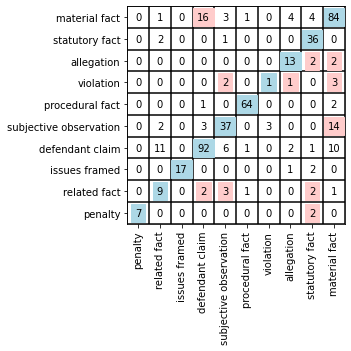

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


height, width = cm.shape
print(height)
print(width)

fig = plt.figure('confusion matrix')
ax = fig.add_subplot(111, aspect='equal')
for x in range(height):
    rowsum = 0
    for y in range(width):
      if x == y:
        ax.annotate(str(cm[width-x-1][height-y-1]), xy=(y, x), ha='center', va='center',backgroundcolor='#ADD8E6')
        rowsum += cm[width-x-1][height-y-1]
      else:
        ax.annotate(str(cm[width-x-1][height-y-1]), xy=(y, x), ha='center', va='center')
        rowsum += cm[width-x-1][height-y-1] 
    #print(f'row {x} sum is {rowsum}')
    for y in range(width):
      if x == y:
        pass
      elif cm[width-x-1][height-y-1] > int(0.1*rowsum):
        ax.annotate(str(cm[width-x-1][height-y-1]), xy=(y, x), ha='center', va='center',backgroundcolor='#ffcccb')
    

offset = .5    
ax.set_xlim(-offset, width - offset)
ax.set_ylim(-offset, height - offset)

ax.hlines(y=np.arange(height+1)- offset, xmin=-offset, xmax=width-offset)
ax.vlines(x=np.arange(width+1) - offset, ymin=-offset, ymax=height-offset)



plt.xticks(range(width), classes,rotation=90)
plt.yticks(range(height), classes)
plt.savefig('confusion_matrix.png', format='png')